In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data_explore import viz
year = 2015
fname = f'../data/SOCATv2024_raw-collocated-1982_2021/SOCATv2024_raw_r20250307-1982_2021/SOCATv2024v_collocated-{year}.pq'
df_raw = pd.read_parquet(fname)
df_raw.head(5)

,expocode,lon,lat,sal,sst_deg_c,pppp_hpa,woa_sss,ncep_slp_hpa,dist_to_land_km,fco2rec_uatm,...,sst_cci_uncertainty,ice_cci,time_sstcci,lat_sstcci,lon_sstcci,sss_cci,sss_cci_random_error,lat_ssscci,lon_ssscci,time_ssscci
1466239,06AQ20141203,351.9279,-70.533,34.253,-1.680,993.0,33.788,992.2,67.0,394.458,...,0.37,0.4,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01
1466240,06AQ20141203,351.9279,-70.533,34.248,-1.685,993.0,33.788,992.2,67.0,393.478,...,0.37,0.4,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01
1466241,06AQ20141203,351.9279,-70.533,34.244,-1.683,993.0,33.788,992.2,67.0,394.124,...,0.37,0.4,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01
1466242,06AQ20141203,351.9279,-70.533,34.241,-1.677,993.0,33.788,992.2,67.0,393.198,...,0.37,0.4,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01
1466243,06AQ20141203,351.9279,-70.533,34.241,-1.678,993.0,33.788,992.2,67.0,393.068,...,0.37,0.4,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01


In [3]:
df_raw['time_1d'] = df_raw['time'].dt.round('D')
df_raw.set_index(['expocode'], inplace=True)

In [19]:
import numpy as np
import pandas as pd
from haversine import haversine_vector
TIME_COL = 'time'
LAT_COL = 'lat'
LON_COL = 'lon'

# mostly chatgpt
def interpolate_ship_positions(df: pd.DataFrame, interval_km=5, max_dist=100):
    df.sort_values(by=TIME_COL, inplace=True)
    # Convert timestamp to numeric (Unix time) for interpolation
    df[TIME_COL] = pd.to_datetime(df[TIME_COL]).astype(int) / 10**9
    
    # Extract latitude, longitude, and timestamps as NumPy arrays
    # lat1, lon1 = df[LAT_COL].values[:-1], df[LON_COL].values[:-1]
    # lat2, lon2 = df[LAT_COL].values[1:], df[LON_COL].values[1:]
    coord = df[[LAT_COL, LON_COL]].values.reshape((-1, 2))
    coord1 = coord[:-1]
    coord2 = coord[1:]
    
    # Compute distances using fast haversine_vector (in km)
    # distances = haversine_vector(list(zip(lat1, lon1)), list(zip(lat2, lon2)), unit='km')
    distances = haversine_vector(coord1, coord2, normalize=True)
    
    # Identify where interpolation is needed
    num_insertions = np.zeros_like(distances, dtype=int)
    mask = (distances > interval_km) * (distances < max_dist)
    num_insertions[mask] = (distances[mask] // interval_km + 1).astype(int)  # Points to add per gap (add one just to be sure)

    if not mask.any(): # if no points must be added just return
        df['interpolated'] = False
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], unit='s')
        return df
    
    # Vectorized interpolation setup
    insert_points = np.repeat(np.arange(len(df) - 1), num_insertions)  # Indices to insert new points
    step_counts = np.hstack([np.arange(1, n + 1) for n in num_insertions])  # Steps for interpolation

    # Extract corresponding values for interpolation
    lat_start, lon_start, time_start = df.iloc[insert_points][[LAT_COL, LON_COL, TIME_COL]].values.T
    lat_end, lon_end, time_end = df.iloc[insert_points + 1][[LAT_COL, LON_COL, TIME_COL]].values.T

    # Compute interpolation factors
    factors = step_counts[:, None] / (num_insertions.repeat(num_insertions)[:, None] + 1)
    # print(insert_points.shape)
    # print(factors.shape)
    
    # Interpolate latitude, longitude, and timestamp
    new_lats = lat_start + factors.flatten() * (lat_end - lat_start)
    lon_diff = (lon_end - lon_start + 180) % 360 - 180  # Ensure shortest path interpolation
    new_lons = ((lon_start + factors.flatten() * lon_diff) % 360).astype(np.float32)  # Keep within [0, 360]
    # new_lons = lon_start + factors.flatten() * (lon_end - lon_start)
    new_times = time_start + factors.flatten() * (time_end - time_start)

    # Create DataFrame for interpolated points
    df_new = pd.DataFrame({LAT_COL: new_lats, LON_COL: new_lons, TIME_COL: new_times})

    # Convert timestamp back to datetime and format as dd-mm-yyyy hh:mm:ss
    df_new[TIME_COL] = pd.to_datetime(df_new[TIME_COL], unit='s')
    df_new['interpolated'] = True

    # Convert original timestamps to correct format before merging
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], unit='s')
    df['interpolated'] = False

    # Merge original and interpolated points, sorting by timestamp
    df_final = pd.concat([df, df_new]).sort_values(by=TIME_COL)

    cruise_id = df.index.unique(level=0)[0]
    df_final['expocode'] = cruise_id
    df_final.set_index('expocode', inplace=True)

    # df_final[LON_COL] = df_final[LON_COL].map(lambda x: f"{x:.6f}")
    
    return df_final


In [20]:
-359 % 360

1

In [21]:

df2 = df_raw.groupby(level=0, group_keys=False).apply(lambda cruise: interpolate_ship_positions(cruise))

In [ ]:
# # expocodes = df_raw['expocode'].unique()
# # cruise_id = expocodes[1]
# expocodes = df_raw.index.get_level_values(level=0).unique()
# cruise_id = expocodes[0]
# df_cruise = df_raw.loc[cruise_id].copy()
# # df_cruise.sort_values(by=TIME_COL, inplace=True)
# df2 = interpolate_ship_positions(df_cruise)
# print(df2.columns)

In [22]:
df2.head()

,lon,lat,sal,sst_deg_c,pppp_hpa,woa_sss,ncep_slp_hpa,dist_to_land_km,fco2rec_uatm,fco2rec_flag,...,time_sstcci,lat_sstcci,lon_sstcci,sss_cci,sss_cci_random_error,lat_ssscci,lon_ssscci,time_ssscci,time_1d,interpolated
expocode,,,,,,,,,,,,,,,,,,,,,
06AQ20141203,351.9279,-70.533,34.253,-1.680,993.0,33.788,992.2,67.0,394.458,2.0,...,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01,2015-01-01,False
06AQ20141203,351.9279,-70.533,34.248,-1.685,993.0,33.788,992.2,67.0,393.478,2.0,...,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01,2015-01-01,False
06AQ20141203,351.9279,-70.533,34.244,-1.683,993.0,33.788,992.2,67.0,394.124,2.0,...,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01,2015-01-01,False
06AQ20141203,351.9279,-70.533,34.241,-1.677,993.0,33.788,992.2,67.0,393.198,2.0,...,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01,2015-01-01,False
06AQ20141203,351.9279,-70.533,34.241,-1.678,993.0,33.788,992.2,67.0,393.068,2.0,...,2015-01-01,-70.525002,351.924988,NaN,NaN,-70.625,351.875,2015-01-01,2015-01-01,False


In [23]:
df2['time_1d'] = df2['time'].dt.round('D')
df2.reset_index(inplace=True)
print(df2.head())
df2_new = df2.set_index(['expocode', 'time_1d', 'lat', 'lon'])
df2_new.head()


       expocode       lon     lat     sal  sst_deg_c  pppp_hpa  woa_sss  \
0  06AQ20141203  351.9279 -70.533  34.253     -1.680     993.0   33.788   
1  06AQ20141203  351.9279 -70.533  34.248     -1.685     993.0   33.788   
2  06AQ20141203  351.9279 -70.533  34.244     -1.683     993.0   33.788   
3  06AQ20141203  351.9279 -70.533  34.241     -1.677     993.0   33.788   
4  06AQ20141203  351.9279 -70.533  34.241     -1.678     993.0   33.788   

   ncep_slp_hpa  dist_to_land_km  fco2rec_uatm  ...  time_sstcci lat_sstcci  \
0         992.2             67.0       394.458  ...   2015-01-01 -70.525002   
1         992.2             67.0       393.478  ...   2015-01-01 -70.525002   
2         992.2             67.0       394.124  ...   2015-01-01 -70.525002   
3         992.2             67.0       393.198  ...   2015-01-01 -70.525002   
4         992.2             67.0       393.068  ...   2015-01-01 -70.525002   

   lon_sstcci  sss_cci  sss_cci_random_error  lat_ssscci lon_ssscci  \
0  

sal  sst_deg_c  pppp_hpa  \
expocode     time_1d    lat     lon                                     
06AQ20141203 2015-01-01 -70.533 351.9279  34.253     -1.680     993.0   
                                351.9279  34.248     -1.685     993.0   
                                351.9279  34.244     -1.683     993.0   
                                351.9279  34.241     -1.677     993.0   
                                351.9279  34.241     -1.678     993.0   

                                          woa_sss  ncep_slp_hpa  \
expocode     time_1d    lat     lon                               
06AQ20141203 2015-01-01 -70.533 351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   

                                          dist_to_land_km  fco2rec_uatm  \
expocode     time_1d    lat     lon                                       
06AQ20141203 2015-01-01 -70.533 351.9279             67.0       394.458   
                                351.9279             67.0       393.478   
                                351.9279             67.0       394.124   
                                351.9279             67.0       393.198   
                                351.9279             67.0       393.068   

                                          fco2rec_flag                time  \
expocode     time_1d    lat     lon                                          
06AQ20141203 2015-01-01 -70.533 351.9279           2.0 2015-01-01 00:00:01   
                                351.9279           2.0 2015-01-01 00:01:07   
                                351.9279           2.0 2015-01-01 00:02:16   
                                351.9279           2.0 2015-01-01 00:03:22   
                                351.9279           2.0 2015-01-01 00:04:28   

                                            year  ...  ice_cci  time_sstcci  \
expocode     time_1d    lat     lon               ...                         
06AQ20141203 2015-01-01 -70.533 351.9279  2015.0  ...      0.4   2015-01-01   
                                351.9279  2015.0  ...      0.4   2015-01-01   
                                351.9279  2015.0  ...      0.4   2015-01-01   
                                351.9279  2015.0  ...      0.4   2015-01-01   
                                351.9279  2015.0  ...      0.4   2015-01-01   

                                          lat_sstcci  lon_sstcci  sss_cci  \
expocode     time_1d    lat     lon                                         
06AQ20141203 2015-01-01 -70.533 351.9279  -70.525002  351.924988      NaN   
                                351.9279  -70.525002  351.924988      NaN   
                                351.9279  -70.525002  351.924988      NaN   
                                351.9279  -70.525002  351.924988      NaN   
                                351.9279  -70.525002  351.924988      NaN   

                                          sss_cci_random_error  lat_ssscci  \
expocode     time_1d    lat     lon                                          
06AQ20141203 2015-01-01 -70.533 351.9279                   NaN     -70.625   
                                351.9279                   NaN     -70.625   
                                351.9279                   NaN     -70.625   
                                351.9279                   NaN     -70.625   
                                351.9279                   NaN     -70.625   

                                          lon_ssscci  time_ssscci  \
expocode     time_1d    lat     lon                                 
06AQ20141203 2015-01-01 -70.533 351.9279     351.875   2015-01-01   
                                351.9279     351.875   2015-01-01   
                                351.9279     351.875   2015-01-01   
    

In [24]:
df_interpolated = df2_new.loc[df2_new.interpolated, ['interpolated', 'time']]
print(df_interpolated.head())
df_interpolated.to_parquet('../data/interpolated_points/interpolated2010')

                                              interpolated  \
expocode     time_1d    lat       lon                        
06AQ20141203 2015-01-02 -70.50792 351.900574          True   
                        -70.48804 351.834656          True   
                        -70.46816 351.768738          True   
                        -70.44828 351.702820          True   
             2015-01-03 -70.47270 351.148438          True   

                                                                      time  
expocode     time_1d    lat       lon                                       
06AQ20141203 2015-01-02 -70.50792 351.900574 2015-01-02 06:30:32.200000048  
                        -70.48804 351.834656 2015-01-02 06:48:20.400000095  
                        -70.46816 351.768738 2015-01-02 07:06:08.599999905  
                        -70.44828 351.702820 2015-01-02 07:23:56.799999952  
             2015-01-03 -70.47270 351.148438 2015-01-03 01:51:46.666666746  


In [42]:
for year in range(1982, 2022):
    fname = f'../data/SOCATv2024_raw-collocated-1982_2021/SOCATv2024_raw_r20250307-1982_2021/SOCATv2024v_collocated-{year}.pq'
    df_raw = pd.read_parquet(fname)
    df_raw.set_index(['expocode'], inplace=True)
    df2 = (df_raw.groupby(level=0, group_keys=False)
           .apply(
               lambda cruise: interpolate_ship_positions(cruise)
               ))
    df2['time_1d'] = df2['time'].dt.round('D')
    df2.reset_index(inplace=True)
    df2_new = df2.set_index(['expocode', 'time_1d', 'lat', 'lon'])
    df_interpolated = df2_new.loc[df2_new.interpolated, ['interpolated', 'time']]
    df_interpolated.to_parquet(f'../data/interpolated_points/interpolated_{year}')
    

# Testing the interpolation function

In [25]:
df2_new.loc[df2_new['sst_cci'].isna(), 'sst_cci']= -1

In [26]:
from itertools import accumulate, chain
import numpy as np
from haversine import haversine_vector

TIME_COL = 'time'
LAT_COL = 'lat'
LON_COL = 'lon'
# TIME_COL = 'time_avg'
# LAT_COL = 'lat_005'
# LON_COL = 'lon_005'
def get_dtoprev(srt_cruise):
    # calculate distance in kms to previous locations
    coords = np.column_stack([
        srt_cruise.index.get_level_values(LAT_COL).to_numpy(),
        srt_cruise.index.get_level_values(LON_COL).to_numpy()
    ])
    
    d = np.full(coords.shape[0], np.nan, dtype=np.float32)
    if coords.shape[0] > 1:
        d[1:] = haversine_vector(coords[1:], coords[:-1], normalize=True)
    
    return d

def ifprint(verbose, data):
    if verbose:
        print(data)

def divide_cruise(cruise, num_windows=64, len_window=5, max_time_delta=pd.Timedelta(days=1000), max_d_delta=np.inf, verbose=False):
    

    srt_cruise = cruise.sort_values(by=TIME_COL)
    d_diff = get_dtoprev(srt_cruise)
    ifprint(verbose, d_diff)
    time_diff = srt_cruise[TIME_COL].diff()
    # ifprint(verbose, time_diff)
    track_len = num_windows * len_window

    cs = 0
    segs = []
    cur_seg = [0]
    large_time_diffs = []
    for (i, dprev) in enumerate(d_diff[1:]):
        cs += dprev
        if dprev > 20:
            large_time_diffs.append(dprev)
        # if the segment length exceeds 64*5 kms or the time jumps than max_time_delta or jumps more than max_d_delta kilometers
        # end the segment
        if cs >= track_len or time_diff.iloc[i + 1] >= max_time_delta or dprev >= max_d_delta:
            segs.append(cur_seg)
            cur_seg = [0]
            cs = 0
        else:
            cur_seg.append(dprev.astype(np.float32))
    if cur_seg:
        segs.append(cur_seg)
    # ifprint(verbose, segs[:4])
    ifprint(verbose, large_time_diffs)

    ix_segs = chain(*[[i]*len(seg) for (i, seg) in enumerate(segs)])
    cum_segs = chain(*[list(accumulate(seg)) for seg in segs])
    
    sdf = pd.DataFrame({'segment_id': list(ix_segs), 'track_length':list(cum_segs)}, index=srt_cruise.index)
    # ifprint(verbose, sdf.iloc[:4].track_length)
    bins = np.arange(-len_window / 2., track_len + len_window, len_window)
    cut_sdf = pd.cut(sdf.track_length, bins=bins, labels=False)
    
    srt_cruise.set_index(cruise.index)
    srt_cruise['bin_id'] = cut_sdf.values
    srt_cruise['segment_id'] = sdf.segment_id
    return srt_cruise

In [27]:
NUM_BINS = 64
LEN_WINDOW = 5
# perform segmentation on the whole dataset
df_bins = df2_new.groupby(level=0, group_keys=False).apply(
    lambda cruise: divide_cruise(cruise,
                                 num_windows=NUM_BINS,
                                 len_window=LEN_WINDOW, 
                                 max_time_delta=pd.Timedelta(days=2)
                                 )
    )
df_bins.head()

sal  sst_deg_c  pppp_hpa  \
expocode     time_1d    lat     lon                                     
06AQ20141203 2015-01-01 -70.533 351.9279  34.253     -1.680     993.0   
                                351.9279  34.248     -1.685     993.0   
                                351.9279  34.244     -1.683     993.0   
                                351.9279  34.241     -1.677     993.0   
                                351.9279  34.241     -1.678     993.0   

                                          woa_sss  ncep_slp_hpa  \
expocode     time_1d    lat     lon                               
06AQ20141203 2015-01-01 -70.533 351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   
                                351.9279   33.788         992.2   

                                          dist_to_land_km  fco2rec_uatm  \
expocode     time_1d    lat     lon                                       
06AQ20141203 2015-01-01 -70.533 351.9279             67.0       394.458   
                                351.9279             67.0       393.478   
                                351.9279             67.0       394.124   
                                351.9279             67.0       393.198   
                                351.9279             67.0       393.068   

                                          fco2rec_flag                time  \
expocode     time_1d    lat     lon                                          
06AQ20141203 2015-01-01 -70.533 351.9279           2.0 2015-01-01 00:00:01   
                                351.9279           2.0 2015-01-01 00:01:07   
                                351.9279           2.0 2015-01-01 00:02:16   
                                351.9279           2.0 2015-01-01 00:03:22   
                                351.9279           2.0 2015-01-01 00:04:28   

                                            year  ...  lat_sstcci  lon_sstcci  \
expocode     time_1d    lat     lon               ...                           
06AQ20141203 2015-01-01 -70.533 351.9279  2015.0  ...  -70.525002  351.924988   
                                351.9279  2015.0  ...  -70.525002  351.924988   
                                351.9279  2015.0  ...  -70.525002  351.924988   
                                351.9279  2015.0  ...  -70.525002  351.924988   
                                351.9279  2015.0  ...  -70.525002  351.924988   

                                          sss_cci sss_cci_random_error  \
expocode     time_1d    lat     lon                                      
06AQ20141203 2015-01-01 -70.533 351.9279      NaN                  NaN   
                                351.9279      NaN                  NaN   
                                351.9279      NaN                  NaN   
                                351.9279      NaN                  NaN   
                                351.9279      NaN                  NaN   

                                          lat_ssscci  lon_ssscci  time_ssscci  \
expocode     time_1d    lat     lon                                             
06AQ20141203 2015-01-01 -70.533 351.9279     -70.625     351.875   2015-01-01   
                                351.9279     -70.625     351.875   2015-01-01   
                                351.9279     -70.625     351.875   2015-01-01   
                                351.9279     -70.625     351.875   2015-01-01   
                                351.9279     -70.625     351.875   2015-01-01   

                                          interpolated  bin_id  segment_id  
expocode     time_1d    lat     lon                                         
06AQ20141203 2015-01-01 -70.533 351.9279         False       0           0  
                                351.9279         False       0           0  
                           

In [ ]:
NUM_BINS = 64
LEN_WINDOW = 5
expocodes = df_bins.index.get_level_values(level=0).unique()
cruise_id =  expocodes[0]
srt_cruise = df_bins.loc[cruise_id]
map = viz.plot_cruise_interactive_scatter_map(srt_cruise.interpolated, #** ((srt_cruise.segment_id % 2 == 0) * 100), # some dumb trick to get hard color changes
                                              cmap='viridis',
                                              lat_name=LAT_COL,
                                              lon_name=LON_COL,
                                              time_name='time_1d') 
# map = viz.plot_cruise_interactive_scatter_map(cruise['5kmtracks'], cmap='viridis')
map

In [15]:
srt_cruise.iloc[19902:19909]

NameError: name 'srt_cruise' is not defined

In [29]:
# function to create the actual numpy array (maybe needlessly complicated)
def df_to_numpy(df2, num_bins):
    binned = df2.groupby([pd.Grouper(level=0), 'segment_id', 'bin_id']).mean() # first bin all values in the 5km buckets found above
    # index level of <binned> : [expocode, segment_id, bin_id]
    bins_per_seg = binned.groupby([pd.Grouper(level=0), pd.Grouper(level=1)]).size() # number of non-empty buckets per segment
    print(bins_per_seg)
    num_segs_tot = bins_per_seg.size # total number of segments in dataset
    segs_per_expocode = bins_per_seg.groupby(level=0).size() # number of segments per expocode
    
    offsets = segs_per_expocode.values.cumsum() # offsets to index segments in expocode table
    offsets_expocode = np.zeros_like(offsets)
    offsets_expocode[1:] = offsets[:-1] # offsets at expocode level
    offsets_seg = np.repeat(offsets_expocode, segs_per_expocode.values)
    offsets_seg = offsets_seg + bins_per_seg.index.get_level_values(level=1).to_numpy() # offset for each segment
    offsets_seg_per_bin = np.repeat(offsets_seg, bins_per_seg) # offset for each bin (row index in dataset does not change)

    predictors = ['sst_cci', 'sss_cci', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km', 
                  'chl_globcolour', 'temp_soda', 'salt_soda', 'mld_dens_soda', 
                  'ssh_adt', 'ssh_sla', 'ice_cci']
    dataset = np.full((len(predictors) + 1, num_segs_tot, num_bins + 1), 
                      np.nan, 
                      dtype=np.float32)
    bin_ids = binned.index.get_level_values(level=2).to_numpy()

    # I only add the fco2 values for the moment
    y = binned.fco2rec_uatm.values
    X = binned[predictors].values.T
    dataset[0, offsets_seg_per_bin, bin_ids] = y
    dataset[1:, offsets_seg_per_bin, bin_ids] = X

    expomap = pd.DataFrame(offsets_seg, index=bins_per_seg.index)

    return dataset, expomap

In [30]:
ds, expomap = df_to_numpy(df_bins, NUM_BINS)

expocode      segment_id
06AQ20141203  0             64
              1             65
              2             65
              3             65
              4             65
                            ..
PAT520151219  21            64
              22            31
PAT520151229  0             65
              1             65
              2             58
Length: 5183, dtype: int64


number of segments for 33RO20150130:  6
[ -1.      289.07498 289.12668 289.112   289.09    289.10666 289.12332
 289.13    289.11667 289.105   289.108   289.1     216.57501  -1.
 192.55998 289.51166 289.59665 289.69    289.69666 289.68    289.63165
 289.59198 289.556   289.53    289.50397 289.5533  289.62     -1.
  -1.       -1.       -1.      289.038   288.89166 288.78198 288.69598
 288.64664 288.594   288.59    288.58    288.565   288.52664 288.498
 288.46335  -1.       -1.      288.565   288.67996 288.81998 288.90802
 288.96    288.986   288.99    288.98166 288.97998 289.03833 289.13998
 289.33167 144.245    -1.      289.81998 289.90332 289.91666 289.898
 289.87332 289.86   ]


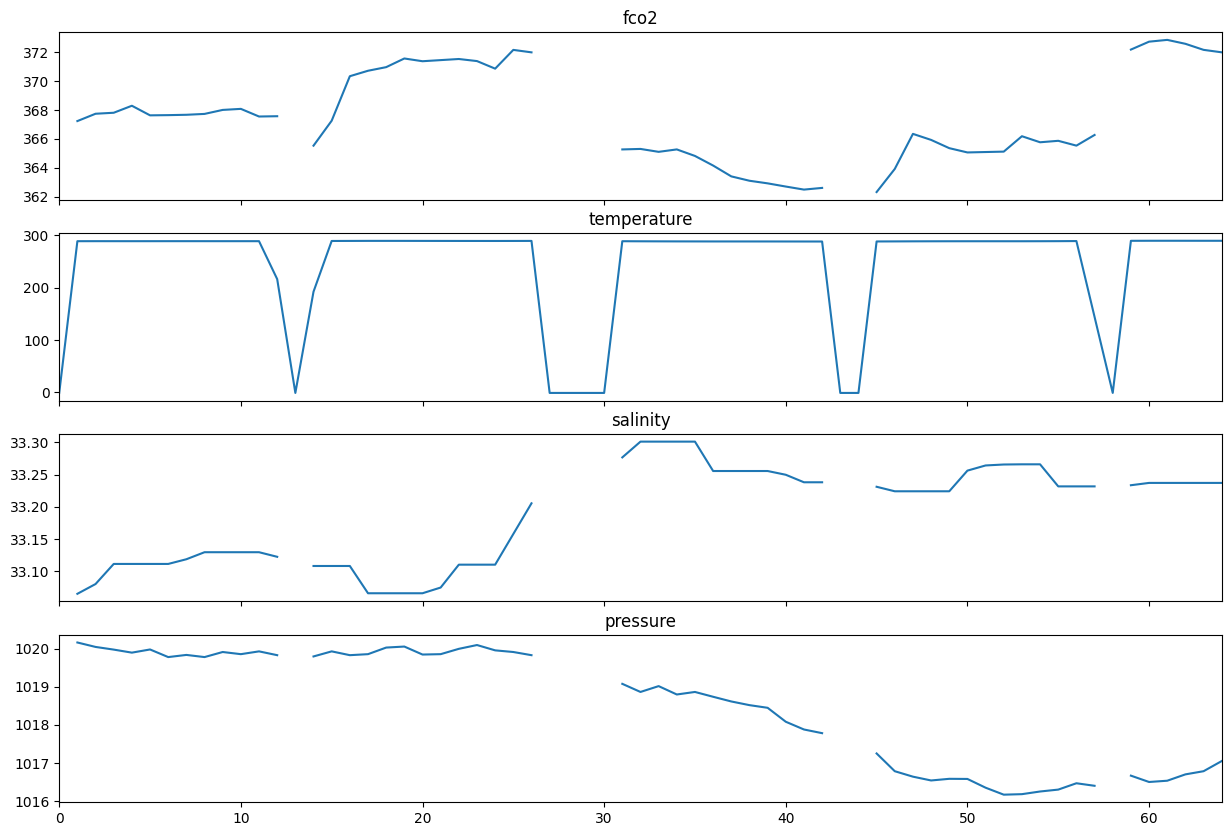

In [37]:
ixs = expomap.loc[cruise_id, :].values.flatten()
print(f"number of segments for {cruise_id}: ", ixs.shape[0])
fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
ix = ixs[3]
print(ds[1, ix])

plt.xlim((0, NUM_BINS))
titles = ['fco2', 'temperature', 'salinity', 'pressure']
for i in [0,1,2,3]:
    axs[i].plot(ds[i, ix])
    axs[i].set_title(titles[i])
plt.show()

dataset shape:  (5183, 65)
total number of entries:  336895
fraction of valid observations:  0.9198741447632052
fraction of segments without any nans:  0.7950993633031063


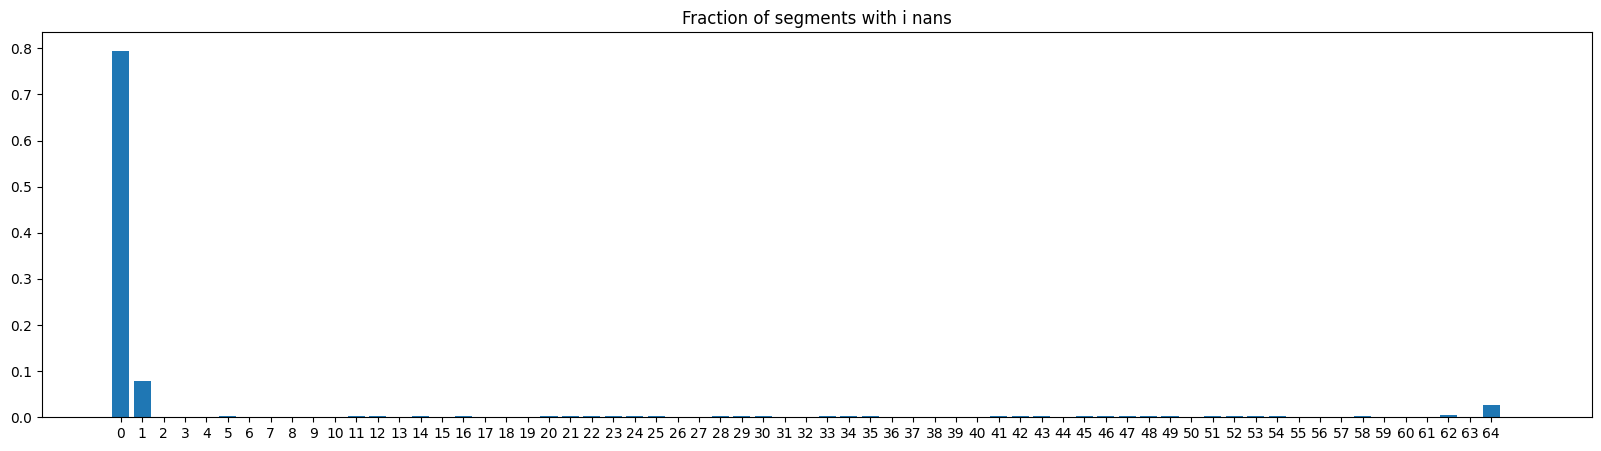

In [42]:
def ds_nanstats(ds):
    n_obs = ds.size
    n_segs, n_bins = ds.shape
    print("dataset shape: ", ds.shape)
    print("total number of entries: ", n_obs)
    notnans = (np.where(~np.isnan(ds))[0]).shape[0]
    print("fraction of valid observations: ", notnans / n_obs)
    nonans = np.apply_along_axis(lambda track: ~np.isnan(track).any(), 1, ds)
    full_tracks = np.where(nonans)[0]
    print("fraction of segments without any nans: ", full_tracks.size / n_segs)
    bins_nan_stat = []
    for i in range(n_bins + 1):
        badsegs = np.apply_along_axis(lambda seg: np.sum(np.isnan(seg)) == i, 1, ds)
        bins_nan_stat.append(badsegs.sum() / n_segs)
    plt.figure(figsize=(20, 5))
    plt.title("Fraction of segments with i nans")
    plt.xticks(np.arange(0, n_bins, 1))
    plt.bar(range(n_bins + 1), bins_nan_stat)
    plt.show

ds_nanstats(ds[1])